In [1]:
import os
os.chdir ("/Users/taky/Library/CloudStorage/GoogleDrive-tahmid@udel.edu/Other computers/My Laptop/UDel/Fall 2023/MAST 638_Machine Learning/MAST638_HWs")

----------------------------------------------
       File Loading Report
----------------------------------------------
  total number: 5 file
         ./data/hw02/station-091028.csv
         ./data/hw02/station-091020.csv
         ./data/hw02/station-091023.csv
         ./data/hw02/station-091026.csv
         ./data/hw02/station-091030.csv
----------------------------------------------
       Data Screening Report for Bay Area
----------------------------------------------
  total 5  stations: 770 records:
      -  82 missing values in  chlora
      -  44 missing values in  water_temp
      -  34 missing values in  tss
      -  44 missing values in  salinity
      -  18 missing values in  phosphate_phosphorus
      -  31 missing values in  nutrient_nitrogen


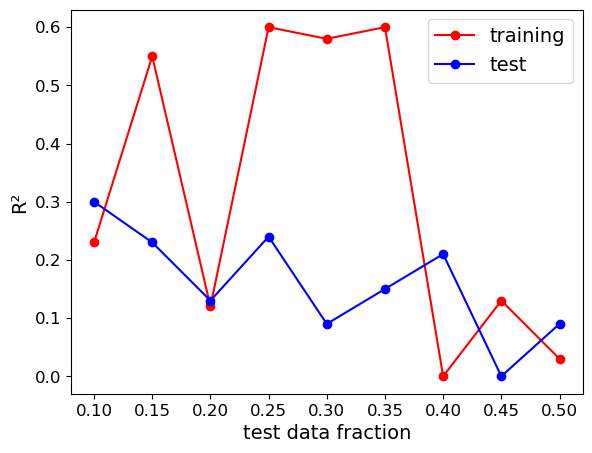

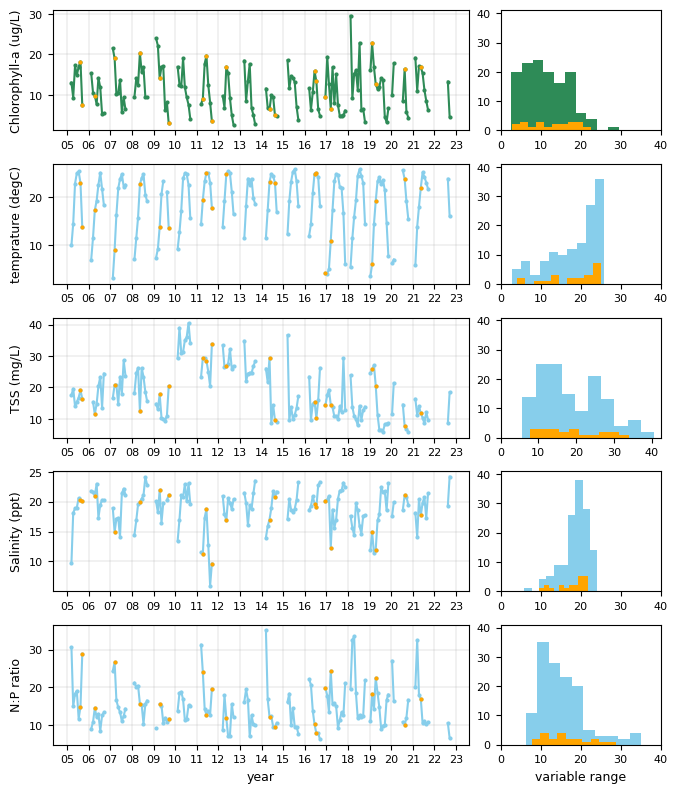

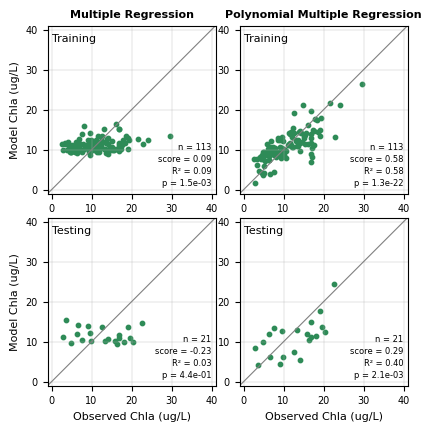

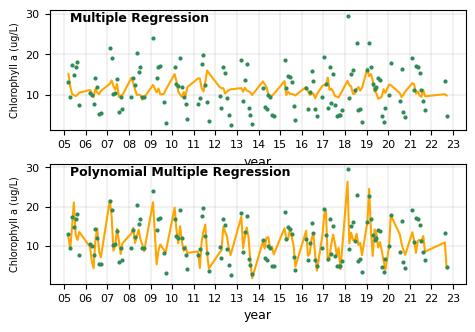

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import datetime as dt
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr

#####################
##  Global Params  ##
#####################
fdir = './data/hw02/'
list_UR = ['332052','332064','332068','892062','892065','892070','892071','892077','892080']
list_ETM = ['091002','091005','091008','091011','091015','091017','332046','332049']
list_BA = ['091020','091023','091026','091028','091030']
vnames = ['chlora_value','water_temp_value', 'tss_value','salinity_value','phosphate_phosphorus_value','nutrient_nitrogen_value']
vdescs = ['Chlorophyll-a (ug/L)', 'temprature (degC)', 'TSS (mg/L)', 'Salinity (ppt)','N:P ratio'] 
#-----------------------------------------
# Time related variables
#-----------------------------------------
mplonths = np.arange(1,13,1)
times = pd.date_range(start="20050101", end="20230101", freq='SM')[0::2]
tappd = times; tappd = tappd.append(times); tappd = tappd.append(times);
#-----------------------------------------
# Outlier cutoff threshold
#-----------------------------------------
lb = 0.05; ub = 96; msplit = 0.20
lb = 0.05; ub = 96; msplit = 0.15  # base
lb = 0.05; ub = 96; msplit = 0.15  # sensitivity
########################
# sensitivity plot
a = np.arange(0.1,0.55,0.05)
#     0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50
b1 = [0.23,0.55,0.12,0.60,0.58,0.60,0.00,0.13,0.03] 
b2 = [0.30,0.23,0.13,0.24,0.09,0.15,0.21,0.00,0.09]
fig = plt.figure();  # Creating an empty object
ax = fig.add_axes([0.1,0.1,0.8,0.8])
plt.plot(a,b1,'ro-',label='training')
plt.plot(a,b2,'bo-',label='test')
plt.xlabel('test data fraction',fontsize=14)
plt.ylabel('R\u00b2',fontsize=14)
plt.legend(fontsize=14)
ax.tick_params(labelsize=12)
plt.savefig('./figures/HW4_fig5_trainVStest', bbox_inches="tight", dpi=300)


#################
##  load file  ##
#################
fnams = glob.glob(''.join([fdir,'station*.csv']))
print('----------------------------------------------')     
print('       File Loading Report')
print('----------------------------------------------')     
print('  total number:',len(fnams), 'file')
ifile = 0; df = pd.DataFrame()
for fnam in fnams:
  print('        ',fnam)  
  df_tmp = pd.read_csv(fnam)
  df_tmp['timestamp']=pd.to_datetime(df_tmp['timestamp']).dt.strftime('%Y-%m-%d')
  df_tmp['mday'] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df_tmp['timestamp']]
  df_tmp['month']= [dt.datetime.strptime(d,'%Y-%m-%d').month for d in df_tmp['timestamp']]
  df_tmp['year'] = [dt.datetime.strptime(d,'%Y-%m-%d').year for d in df_tmp['timestamp']]   
  #---------------------------
  # Station to Region
  #---------------------------
  df_tmp['region'] = 3
  if fnam[-10:-4:1] in list_UR:
      df_tmp['region'] = 1
  if fnam[-10:-4:1] in list_ETM:
      df_tmp['region'] = 2
  df = pd.concat([df,df_tmp])
  ifile = ifile+1
del ifile, df_tmp

##############################
## DataFrame for statistics ##
##############################
mstat = pd.DataFrame()
for ireg in [3]:
  if ireg==1:
    mlist = list_UR; rdesc = 'Urban River'
  elif ireg==2:
    mlist = list_ETM; rdesc = 'ETM'
  elif ireg==3:
    mlist = list_BA; rdesc = 'Bay Area'
  print('----------------------------------------------')     
  print('       Data Screening Report for', rdesc)
  print('----------------------------------------------')     
  print('  total', len(mlist), ' stations:',len(df.loc[df.region==ireg]), 'records:')
  mwrk = pd.DataFrame(); mwrk.index = times; mwrk['region'] = ireg
  for vname in vnames:
    #----------------------------------------
    # remove outliers
    #----------------------------------------
    dfb = df.loc[df.region==ireg].copy(deep=True);
    tmp = df[vname].loc[df.region==ireg]
    #dfb.loc[tmp<np.percentile(df.loc[tmp.notnull(), vname], lb),vname] = np.nan
    dfb.loc[tmp>np.percentile(dfb.loc[tmp.notnull(), vname], ub),vname] = np.nan
    print('      - ', dfb[vname].isnull().sum(), 'missing values in ',vname[:-6])
    del tmp

    #---------------------------------------------------
    # monthly binning: insert column with default values
    #---------------------------------------------------
    vnum = vname[:-5]+'num'
    mwrk[vnum] = 0
    mwrk[vname] = np.nan  
    for tnow in times:
      tmp = dfb.loc[(dfb.year==tnow.year) 
                  & (dfb.month==tnow.month)
                  & (dfb[vname].notnull()),vname]
      tstr = tnow.strftime('%Y%m%d')
      mwrk.loc[tstr:tstr,vnum ] = len(tmp)
      mwrk.loc[tstr:tstr,vname] = tmp.mean()
    del tmp,tstr
# alternative for monthly binning    
#    nwrk = dfb.groupby(by=[dfb.year, dfb.month])['chlora_value'].mean()
  mstat = pd.concat([mstat,mwrk])
mstat['N2P'] = np.divide(mstat['nutrient_nitrogen_value'],
                        mstat['phosphate_phosphorus_value'])

#-----------------------
# drop missing values
#-----------------------
mwrk = mstat.copy(deep=True)
mwrk = mwrk.dropna(axis=0)

##########################################
## Split data into training and testing ##
##########################################
X_train, X_test, Y_train, Y_test = train_test_split(
  mwrk,               # features
  mwrk.chlora_value,  # labels
  test_size = msplit,   # split ratio
  random_state = 3,   # set random seed
  stratify = None)    # no randomize based on labels

# #-------------------------------------------------
# # plot of variables
# #-------------------------------------------------  
# # Figure setup
fgx=0.05; fgw=0.65; fgdw=0.70
fgy=0.60; fgh=0.25; fgdh=0.32
fig = plt.figure(); ipl=0  # Creating an empty object
colors = ['seagreen','skyblue','skyblue','skyblue','skyblue']
ffig = './figures/HW4_fig1_datasplit'
vnames[4] = "N2P"
for vname in vnames[0:5]:
  ax = fig.add_axes([fgx,fgy-fgdh*ipl,fgw,fgh])
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))  
  ax.tick_params(labelsize=8)
  plt.plot(mstat.index,mstat[vname],'o-',markersize=2,color=colors[ipl]) 
  plt.plot(X_test.index,X_test[vname],'o',markersize=2,color='orange') 
  plt.grid(True,linewidth=0.25)
  plt.ylabel(vdescs[ipl],fontsize=9)
  if ipl==4:
      plt.xlabel('year',fontsize=9)
  
  ax = fig.add_axes([fgx+fgdw,fgy-fgdh*ipl,0.25,fgh])
  #ax.tick_params(labelsize=8)
  plt.hist(mwrk[vname],color = colors[ipl])
  plt.hist(X_test[vname],color = "orange")
  plt.ylim(0,41) 
  plt.yticks(np.arange(0,42,10),fontsize=8)  
  plt.xticks(np.arange(0,50,10),fontsize=8)  
  if ipl==4:
      plt.xlabel('variable range',fontsize=9)
  ipl = ipl+1
plt.savefig(ffig, bbox_inches="tight", dpi=300)
  
#########################
##  Linear Regression  ##
#########################
# u = ((y_test - y_predicted) ** 2).sum()
# v = ((y_test - y_test.mean()) ** 2).sum()
# score = 1 - (u/v)
#-------------------------------------
# Multiple Linear Regression
#-------------------------------------
model = LinearRegression()
model.fit(X_train[vnames[1:5]], Y_train)
# Statistics
MR_Yp_train = model.predict(X_train[vnames[1:5]])
MR_Yp_test  = model.predict(X_test[vnames[1:5]])
MR_Sc_train = model.score(X_train[vnames[1:5]],Y_train)
MR_Sc_test  = model.score(X_test[vnames[1:5]],Y_test)
#-------------------------------------
# Polynomial Multiple Regression
#-------------------------------------
polynomial_features= PolynomialFeatures(degree = 3)
X_train_poly = polynomial_features.fit_transform(X_train[vnames[1:5]])
X_test_poly  = polynomial_features.fit_transform(X_test[vnames[1:5]])
model = LinearRegression()
model.fit(X_train_poly, Y_train)
PMR_Yp_test  = model.predict(X_test_poly)
PMR_Yp_train = model.predict(X_train_poly)
PMR_Sc_test = model.score(X_test_poly,Y_test)
PMR_Sc_train = model.score(X_train_poly,Y_train)
#-------------------------------------
# plot of results
#-------------------------------------
fgx=0.05; fgw=0.35; fgdw=0.30
fgy=0.60; fgh=0.35; fgdh=0.40
fig = plt.figure(); ipl=0  # Creating an empty object
ffig = './figures/HW4_fig2_RegressModels_'+str(int(msplit*100))
mline = np.arange(-1,50,0.2)
for imodel in [1,2,3,4]:
  if imodel==1:
    Y=Y_train; Yp=MR_Yp_train; Sc=MR_Sc_train; desc = 'Training'
  elif imodel==2:
    Y=Y_test;  Yp=MR_Yp_test; Sc=MR_Sc_test;  desc = 'Testing'
  elif imodel==3:
    Y=Y_train; Yp=PMR_Yp_train; Sc=PMR_Sc_train;  desc = 'Training'
  elif imodel==4:
    Y=Y_test;  Yp=PMR_Yp_test; Sc=PMR_Sc_test;  desc = 'Testing'
  #--------- more statistics ---------------
  cff = pearsonr(Y,Yp)
  R2 = cff[0]**2
  pval = cff[1]  
  #----------- TRAINING -----------
  ax = fig.add_axes([fgx+fgdw*(imodel>2),fgy-fgdh*np.remainder(imodel+1,2),fgw,fgh])
  ax.tick_params(labelsize=7)
  plt.scatter(Y,Yp,s=10,color='seagreen') 
  plt.plot(mline,mline,'-',color='gray',linewidth=0.8) 
  plt.grid(True,linewidth=0.25)
  plt.ylim(-1,41) 
  plt.xlim(-1,41)   
  plt.yticks(np.arange(0,50,10))
  ax.set_aspect('equal', adjustable='box')
  #------------ additional adjustments -----------
  plt.text(0,37,desc,fontsize=8,horizontalalignment='left')
  plt.text(40,10,'n = %i' % len(Y),fontsize=6,horizontalalignment='right')
  plt.text(40,7,'score = %.2f' % Sc, fontsize=6,horizontalalignment='right')    
  plt.text(40,4,'R\u00b2 = %.2f' % R2, fontsize=6,horizontalalignment='right')
  plt.text(40,1,'p = %.1e' % pval,fontsize=6,horizontalalignment='right')
  if imodel==1:
    plt.title('Multiple Regression',fontsize=8,fontweight='bold')
    plt.ylabel('Model Chla (ug/L)',fontsize=8)
  elif imodel==3:
    plt.title('Polynomial Multiple Regression',fontsize=8,fontweight='bold') 
  elif imodel==2:
    plt.xlabel('Observed Chla (ug/L)',fontsize=8)
    plt.ylabel('Model Chla (ug/L)',fontsize=8)
  elif imodel==4:
    plt.xlabel('Observed Chla (ug/L)',fontsize=8)
plt.savefig(ffig, bbox_inches="tight", dpi=300)

#########################
## plot reconstruction ##
#########################
# Figure setup
fgx=0.05; fgw=0.65; fgdw=0.70
fgy=0.60; fgh=0.25; fgdh=0.32
fig = plt.figure(); ipl=0  # Creating an empty object
colors = ['seagreen','skyblue','skyblue','skyblue','skyblue']
ffig = './figures/HW4_fig3_reconstruction'
rdf = pd.DataFrame(pd.concat([Y_train,Y_test]))
rdf['resc_MR' ] =  np.concatenate((MR_Yp_train,MR_Yp_test)).T
rdf['resc_PMR'] =  np.concatenate((PMR_Yp_train,PMR_Yp_test)).T
rdf = rdf.sort_index()
for imodel in [1,2]:
  ax = fig.add_axes([fgx,fgy-fgdh*(imodel-1),fgw,fgh])
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))  
  ax.tick_params(labelsize=8)
  if imodel==1:
    plt.plot(rdf.index,rdf.resc_MR,'-',markersize=2,color='orange') 
    plt.text(rdf.index[1],28,'Multiple Regression',fontsize=9,horizontalalignment='left',fontweight='bold')
  else:  
    plt.plot(rdf.index,rdf.resc_PMR,'-',markersize=2,color='orange') 
    plt.text(rdf.index[1],28,'Polynomial Multiple Regression',fontsize=9,horizontalalignment='left',fontweight='bold')
  plt.plot(rdf.index,rdf.chlora_value,'o',markersize=2,color='seagreen') 
  plt.grid(True,linewidth=0.25)
  plt.ylabel('Chlorophyll a (ug/L)',fontsize=7)
  plt.xlabel('year',fontsize=9)
plt.savefig(ffig, bbox_inches="tight", dpi=300)


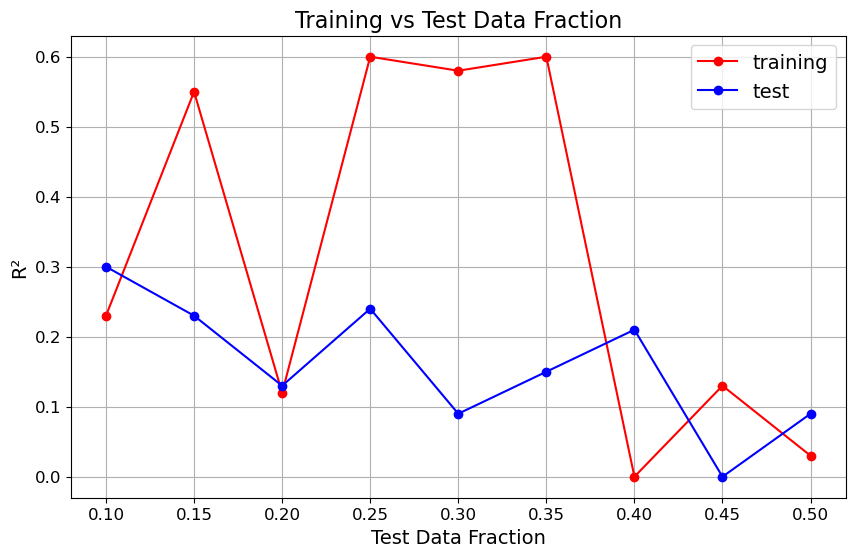

----------------------------------------------
       File Loading Report
----------------------------------------------
  Total number: 5 files
         ./data/hw02/station-091028.csv
         ./data/hw02/station-091020.csv
         ./data/hw02/station-091023.csv
         ./data/hw02/station-091026.csv
         ./data/hw02/station-091030.csv
----------------------------------------------
       Data Screening Report for Bay Area
----------------------------------------------
  Total 5 stations: 770 records:
      -  82 missing values in chlora
      -  44 missing values in water_temp
      -  34 missing values in tss
      -  44 missing values in salinity
      -  18 missing values in phosphate_phosphorus
      -  31 missing values in nutrient_nitrogen


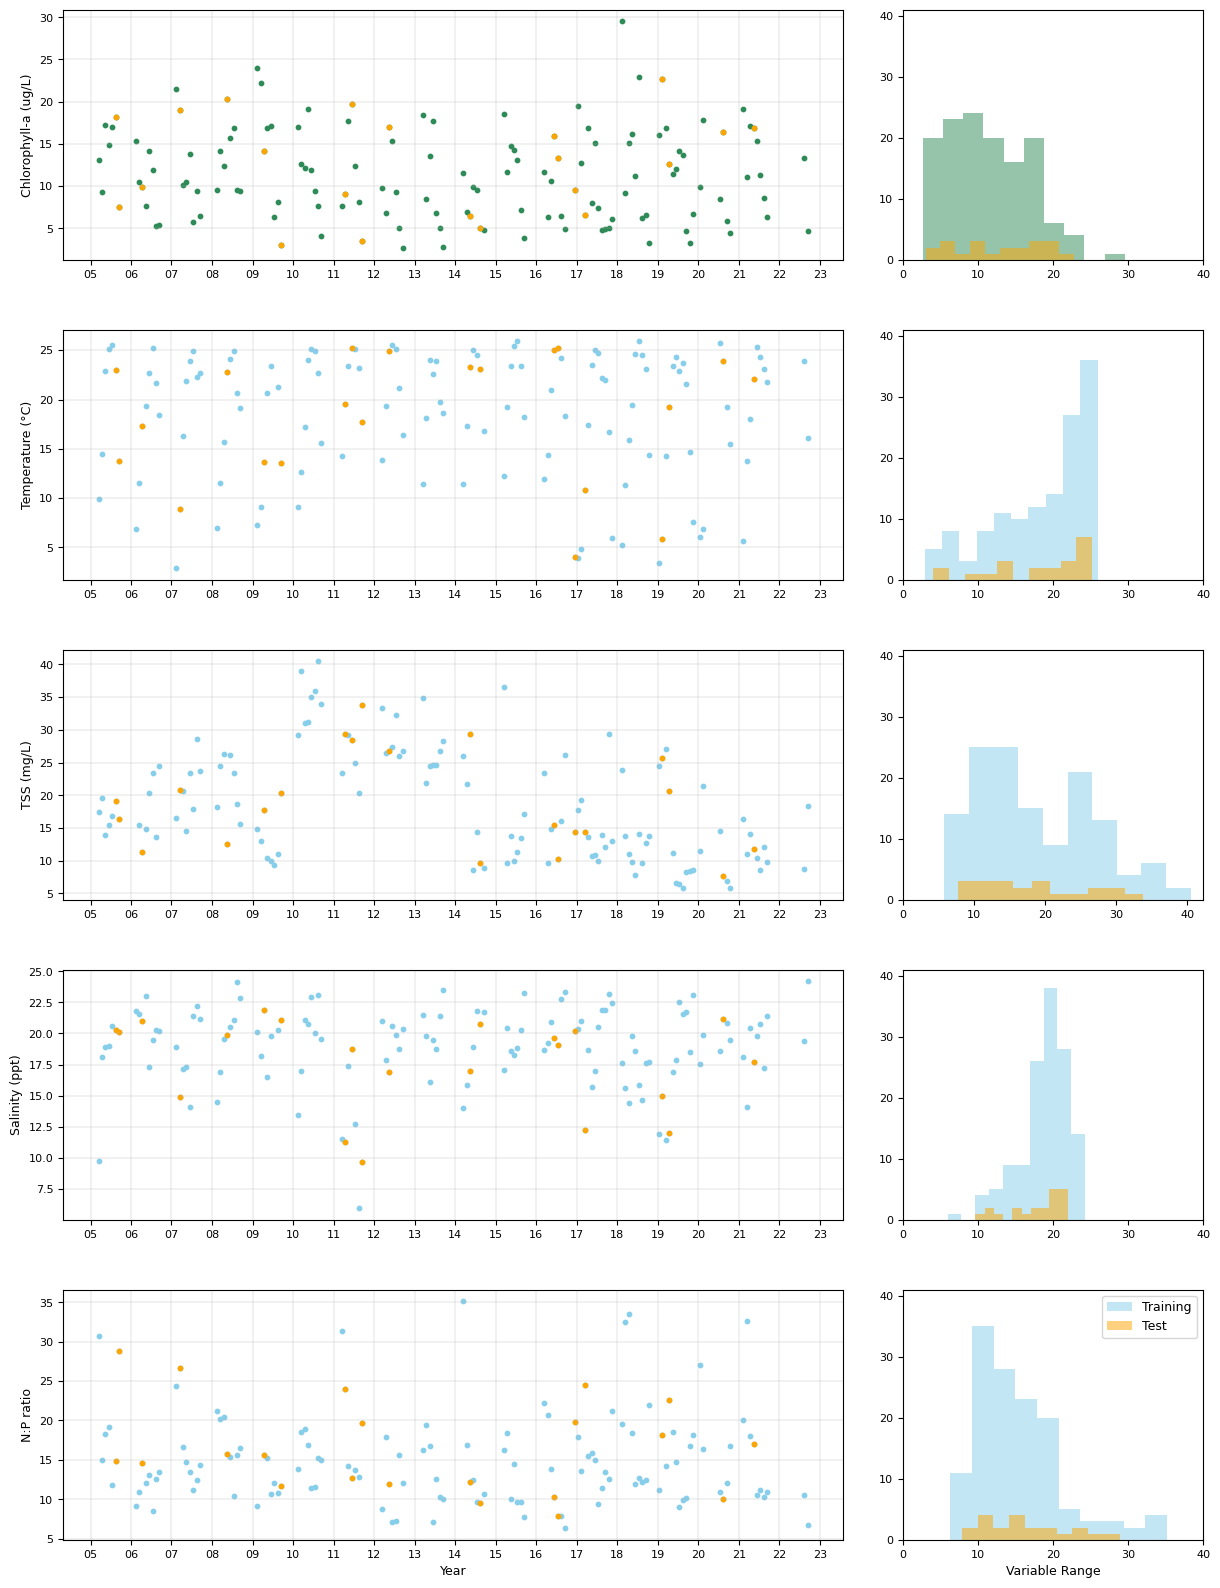

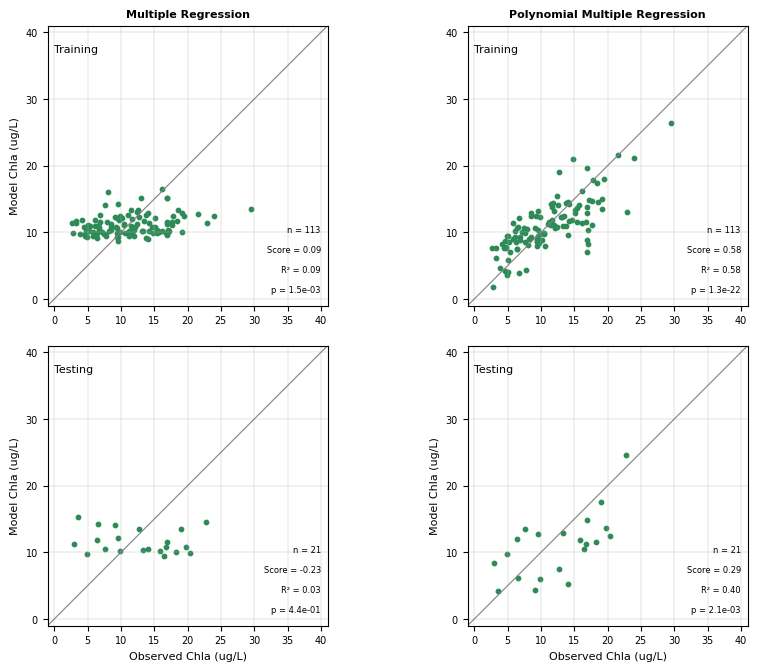

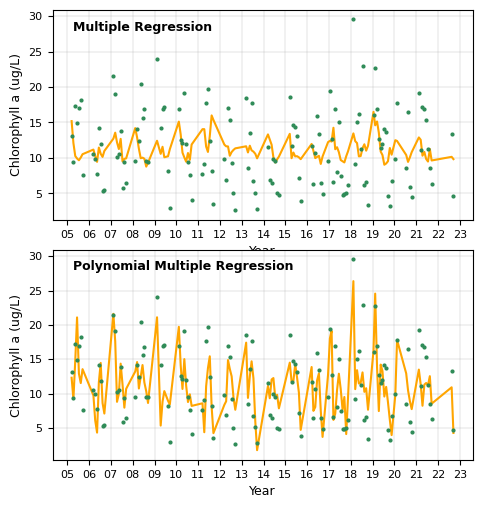

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import datetime as dt
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr

#####################
##  Global Params  ##
#####################
fdir = './data/hw02/'
list_UR = ['332052','332064','332068','892062','892065','892070','892071','892077','892080']
list_ETM = ['091002','091005','091008','091011','091015','091017','332046','332049']
list_BA = ['091020','091023','091026','091028','091030']
vnames = ['chlora_value','water_temp_value', 'tss_value','salinity_value','phosphate_phosphorus_value','nutrient_nitrogen_value']
vdescs = ['Chlorophyll-a (ug/L)', 'Temperature (°C)', 'TSS (mg/L)', 'Salinity (ppt)','N:P ratio'] 

# Time related variables
mplonths = np.arange(1,13,1)
times = pd.date_range(start="20050101", end="20230101", freq='SM')[0::2]
tappd = times; tappd = tappd.append(times); tappd = tappd.append(times);

# Outlier cutoff threshold
lb = 0.05; ub = 96; msplit = 0.20
lb = 0.05; ub = 96; msplit = 0.15  # base
lb = 0.05; ub = 96; msplit = 0.15  # sensitivity

########################
# Sensitivity plot
########################
a = np.arange(0.1,0.55,0.05)
b1 = [0.23,0.55,0.12,0.60,0.58,0.60,0.00,0.13,0.03] 
b2 = [0.30,0.23,0.13,0.24,0.09,0.15,0.21,0.00,0.09]
fig = plt.figure(figsize=(10, 6))
plt.plot(a, b1, 'ro-', label='training')
plt.plot(a, b2, 'bo-', label='test')
plt.xlabel('Test Data Fraction', fontsize=14)
plt.ylabel('R²', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tick_params(labelsize=12)
plt.title('Training vs Test Data Fraction', fontsize=16)
plt.savefig('./figures/HW4_fig5_trainVStest', bbox_inches="tight", dpi=300)
plt.show()

#################
## Load file   ##
#################
fnams = glob.glob(''.join([fdir,'station*.csv']))
print('----------------------------------------------')     
print('       File Loading Report')
print('----------------------------------------------')     
print('  Total number:', len(fnams), 'files')
ifile = 0; df = pd.DataFrame()
for fnam in fnams:
    print('        ', fnam)  
    df_tmp = pd.read_csv(fnam)
    df_tmp['timestamp'] = pd.to_datetime(df_tmp['timestamp']).dt.strftime('%Y-%m-%d')
    df_tmp['mday'] = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in df_tmp['timestamp']]
    df_tmp['month'] = [dt.datetime.strptime(d, '%Y-%m-%d').month for d in df_tmp['timestamp']]
    df_tmp['year'] = [dt.datetime.strptime(d, '%Y-%m-%d').year for d in df_tmp['timestamp']]   
    df_tmp['region'] = 3
    if fnam[-10:-4:1] in list_UR:
        df_tmp['region'] = 1
    if fnam[-10:-4:1] in list_ETM:
        df_tmp['region'] = 2
    df = pd.concat([df, df_tmp])
    ifile += 1
del ifile, df_tmp

##############################
## DataFrame for statistics ##
##############################
mstat = pd.DataFrame()
for ireg in [3]:
    if ireg == 1:
        mlist = list_UR; rdesc = 'Urban River'
    elif ireg == 2:
        mlist = list_ETM; rdesc = 'ETM'
    elif ireg == 3:
        mlist = list_BA; rdesc = 'Bay Area'
    print('----------------------------------------------')     
    print('       Data Screening Report for', rdesc)
    print('----------------------------------------------')     
    print('  Total', len(mlist), 'stations:', len(df.loc[df.region == ireg]), 'records:')
    mwrk = pd.DataFrame(); mwrk.index = times; mwrk['region'] = ireg
    for vname in vnames:
        dfb = df.loc[df.region == ireg].copy(deep=True)
        tmp = df[vname].loc[df.region == ireg]
        dfb.loc[tmp > np.percentile(dfb.loc[tmp.notnull(), vname], ub), vname] = np.nan
        print('      - ', dfb[vname].isnull().sum(), 'missing values in', vname[:-6])
        del tmp

        # Monthly binning: insert column with default values
        vnum = vname[:-5] + 'num'
        mwrk[vnum] = 0
        mwrk[vname] = np.nan  
        for tnow in times:
            tmp = dfb.loc[(dfb.year == tnow.year) 
                        & (dfb.month == tnow.month)
                        & (dfb[vname].notnull()), vname]
            tstr = tnow.strftime('%Y%m%d')
            mwrk.loc[tstr:tstr, vnum ] = len(tmp)
            mwrk.loc[tstr:tstr, vname] = tmp.mean()
        del tmp, tstr

    mstat = pd.concat([mstat, mwrk])
mstat['N2P'] = np.divide(mstat['nutrient_nitrogen_value'], mstat['phosphate_phosphorus_value'])

# Drop missing values
mwrk = mstat.copy(deep=True)
mwrk = mwrk.dropna(axis=0)

##########################################
## Split data into training and testing ##
##########################################
X_train, X_test, Y_train, Y_test = train_test_split(
  mwrk,               # features
  mwrk.chlora_value,  # labels
  test_size=msplit,   # split ratio
  random_state=3,     # set random seed
  stratify=None       # no randomize based on labels
)

#########################
## Plot of Variables   ##
#########################
fgx = 0.05; fgw = 0.65; fgdw = 0.70
fgy = 0.60; fgh = 0.25; fgdh = 0.32
fig = plt.figure(figsize=(12, 10))
ipl = 0
colors = ['seagreen', 'skyblue', 'skyblue', 'skyblue', 'skyblue']
ffig = './figures/HW4_fig1_datasplit'
vnames[4] = "N2P"
for vname in vnames[0:5]:
    ax = fig.add_axes([fgx, fgy-fgdh*ipl, fgw, fgh])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))  
    ax.tick_params(labelsize=8)
    plt.scatter(mstat.index, mstat[vname], s=10, color=colors[ipl]) 
    plt.scatter(X_test.index, X_test[vname], s=10, color='orange') 
    plt.grid(True, linewidth=0.25)
    plt.ylabel(vdescs[ipl], fontsize=9)
    if ipl == 4:
        plt.xlabel('Year', fontsize=9)
  
    ax_hist = fig.add_axes([fgx+fgdw, fgy-fgdh*ipl, 0.25, fgh])
    plt.hist(mwrk[vname], color=colors[ipl], alpha=0.5, label='Training')
    plt.hist(X_test[vname], color="orange", alpha=0.5, label='Test')
    plt.ylim(0, 41) 
    plt.yticks(np.arange(0, 42, 10), fontsize=8)  
    plt.xticks(np.arange(0, 50, 10), fontsize=8)  
    if ipl == 4:
        plt.xlabel('Variable Range', fontsize=9)
    ipl += 1

plt.legend(loc='upper right', fontsize=9)
plt.savefig(ffig, bbox_inches="tight", dpi=300)
plt.show()

#########################
##  Linear Regression  ##
#########################
model = LinearRegression()
model.fit(X_train[vnames[1:5]], Y_train)
MR_Yp_train = model.predict(X_train[vnames[1:5]])
MR_Yp_test  = model.predict(X_test[vnames[1:5]])
MR_Sc_train = model.score(X_train[vnames[1:5]], Y_train)
MR_Sc_test  = model.score(X_test[vnames[1:5]], Y_test)

############################
## Polynomial Regression  ##
############################
polynomial_features = PolynomialFeatures(degree=3)
X_train_poly = polynomial_features.fit_transform(X_train[vnames[1:5]])
X_test_poly  = polynomial_features.fit_transform(X_test[vnames[1:5]])
model = LinearRegression()
model.fit(X_train_poly, Y_train)
PMR_Yp_test  = model.predict(X_test_poly)
PMR_Yp_train = model.predict(X_train_poly)
PMR_Sc_test = model.score(X_test_poly, Y_test)
PMR_Sc_train = model.score(X_train_poly, Y_train)

##############################
## Plot Regression Results  ##
##############################
fgx = 0.05; fgw = 0.35; fgdw = 0.30
fgy = 0.60; fgh = 0.35; fgdh = 0.40
fig = plt.figure(figsize=(14, 8))
ipl = 0  
ffig = './figures/HW4_fig2_RegressModels_' + str(int(msplit * 100))
mline = np.arange(-1, 50, 0.2)
for imodel in [1, 2, 3, 4]:
    if imodel == 1:
        Y = Y_train; Yp = MR_Yp_train; Sc = MR_Sc_train; desc = 'Training'
    elif imodel == 2:
        Y = Y_test;  Yp = MR_Yp_test; Sc = MR_Sc_test;  desc = 'Testing'
    elif imodel == 3:
        Y = Y_train; Yp = PMR_Yp_train; Sc = PMR_Sc_train;  desc = 'Training'
    elif imodel == 4:
        Y = Y_test;  Yp = PMR_Yp_test; Sc = PMR_Sc_test;  desc = 'Testing'
    
    cff = pearsonr(Y, Yp)
    R2 = cff[0] ** 2
    pval = cff[1]
    
    ax = fig.add_axes([fgx + fgdw * (imodel > 2), fgy - fgdh * np.remainder(imodel + 1, 2), fgw, fgh])
    ax.tick_params(labelsize=7)
    plt.scatter(Y, Yp, s=10, color='seagreen') 
    plt.plot(mline, mline, '-', color='gray', linewidth=0.8) 
    plt.grid(True, linewidth=0.25)
    plt.ylim(-1, 41) 
    plt.xlim(-1, 41)   
    plt.yticks(np.arange(0, 50, 10))
    ax.set_aspect('equal', adjustable='box')
    
    plt.text(0, 37, desc, fontsize=8, horizontalalignment='left')
    plt.text(40, 10, 'n = %i' % len(Y), fontsize=6, horizontalalignment='right')
    plt.text(40, 7, 'Score = %.2f' % Sc, fontsize=6, horizontalalignment='right')    
    plt.text(40, 4, 'R² = %.2f' % R2, fontsize=6, horizontalalignment='right')
    plt.text(40, 1, 'p = %.1e' % pval, fontsize=6, horizontalalignment='right')
    
    if imodel == 1:
        plt.title('Multiple Regression', fontsize=8, fontweight='bold')
        plt.ylabel('Model Chla (ug/L)', fontsize=8)
    elif imodel == 3:
        plt.title('Polynomial Multiple Regression', fontsize=8, fontweight='bold') 
    elif imodel == 2 or imodel == 4:
        plt.xlabel('Observed Chla (ug/L)', fontsize=8)
        plt.ylabel('Model Chla (ug/L)', fontsize=8)

plt.savefig(ffig, bbox_inches="tight", dpi=300)
plt.show()

#########################
## Plot Reconstruction ##
#########################
fig = plt.figure(figsize=(12, 6))
ipl = 0  
colors = ['seagreen', 'skyblue', 'skyblue', 'skyblue', 'skyblue']
ffig = './figures/HW4_fig3_reconstruction'
rdf = pd.DataFrame(pd.concat([Y_train, Y_test]))
rdf['resc_MR'] = np.concatenate((MR_Yp_train, MR_Yp_test)).T
rdf['resc_PMR'] = np.concatenate((PMR_Yp_train, PMR_Yp_test)).T
rdf = rdf.sort_index()
for imodel in [1, 2]:
    ax = fig.add_axes([fgx, fgy - fgdh * (imodel - 1), fgw, fgh])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))  
    ax.tick_params(labelsize=8)
    if imodel == 1:
        plt.plot(rdf.index, rdf.resc_MR, '-', color='orange') 
        plt.text(rdf.index[1], 28, 'Multiple Regression', fontsize=9, horizontalalignment='left', fontweight='bold')
    else:  
        plt.plot(rdf.index, rdf.resc_PMR, '-', color='orange') 
        plt.text(rdf.index[1], 28, 'Polynomial Multiple Regression', fontsize=9, horizontalalignment='left', fontweight='bold')
    plt.plot(rdf.index, rdf.chlora_value, 'o', markersize=2, color='seagreen') 
    plt.grid(True, linewidth=0.25)
    plt.ylabel('Chlorophyll a (ug/L)', fontsize=9)
    plt.xlabel('Year', fontsize=9)

plt.savefig(ffig, bbox_inches="tight", dpi=300)
plt.show()
